In [2]:
# --- Imports ---
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shutil

In [3]:
# --- Parameters ---
img_size = 128
batch_size = 32
epochs = 15
base_path = r"C:\Users\athit\Downloads\GrapeVine\Grapevine_Leaves_Image_Dataset"
image_folder = os.path.join(base_path, 'images')
train_folder = os.path.join(base_path, 'train')
test_folder = os.path.join(base_path, 'test')

In [4]:
# --- Data Preparation  ---
'''
If you have no previous experience with CNN i would suggest you manually split the dataset
as it might be easy use a 80 20 split
'''
def prepare_data(image_folder, train_folder, test_folder, test_size=0.2):
    """Prepares data by splitting it into train and test sets"""
    if not os.path.exists(train_folder): os.makedirs(train_folder)
    if not os.path.exists(test_folder): os.makedirs(test_folder)

    for class_name in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_name)
        if not os.path.isdir(class_path): continue

        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        if len(images) < 2:  # Skip class if it has less than 2 images
            print(f"Skipping class '{class_name}' because it has less than 2 images.")
            continue

        # Split the images into train and test sets
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)

        # Create class folders inside train and test folders
        os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

        # Copy images into respective folders
        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))
        for img in test_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_folder, class_name, img))

In [5]:
# ---  Data Loading Function ---
def load_data(folder):
    """Loads data from the specified folder and returns images, labels, and class names"""
    data, labels = [], []
    class_labels = os.listdir(folder)

    for label_idx, class_name in enumerate(class_labels):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            # Load images and normalize them
            images = [image.img_to_array(image.load_img(os.path.join(class_path, img), target_size=(img_size, img_size))) / 255.0 
                      for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
            data.extend(images)
            labels.extend([label_idx] * len(images))

    return np.array(data), np.array(labels), class_labels

In [6]:
# If you need to split data
prepare_data(image_folder, train_folder, test_folder)

# --- Load Data (Manually split into train/test folders) ---
train_data, train_labels, class_labels = load_data(train_folder)
test_data, test_labels, _ = load_data(test_folder)

In [7]:
# --- Model Definition ---
model = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'), layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'), layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'), layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3), layers.Flatten(),
    layers.Dense(256, activation='relu'), layers.Dropout(0.3),
    layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,517,317 (24.86 MB)

 Trainable params: 6,517,317 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 698ms/step - accuracy: 0.1832 - loss: 2.6587 - val_accuracy: 0.2000 - val_loss: 1.6076
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 806ms/step - accuracy: 0.2113 - loss: 1.6104 - val_accuracy: 0.3300 - val_loss: 1.6007
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 539ms/step - accuracy: 0.2877 - loss: 1.5959 - val_accuracy: 0.3700 - val_loss: 1.5692
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 794ms/step - accuracy: 0.2909 - loss: 1.5586 - val_accuracy: 0.2900 - val_loss: 1.5460
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.3823 - loss: 1.5065 - val_accuracy: 0.2800 - val_loss: 1.4980
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - accuracy: 0.4387 - loss: 1.3961 - val_accuracy: 0.3800 - val_loss: 1.4606
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.4556 - loss: 1.3299 - val_accuracy: 0.4400 - val_loss: 1.3536
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - accuracy: 0.5689 - loss: 1.1522 - val_accuracy:

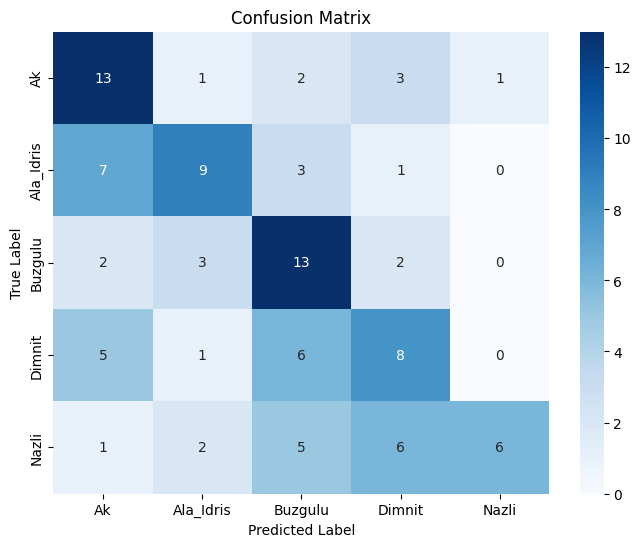

In [8]:
# --- Training ---
history = model.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels), batch_size=batch_size)

# --- Evaluation ---
loss, acc = model.evaluate(test_data, test_labels)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")

# --- Confusion Matrix & Classification Report ---
y_pred_classes = np.argmax(model.predict(test_data), axis=1)

print("Classification Report:\n", classification_report(test_labels, y_pred_classes, target_names=class_labels))

# Confusion Matrix Plot
cm = confusion_matrix(test_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

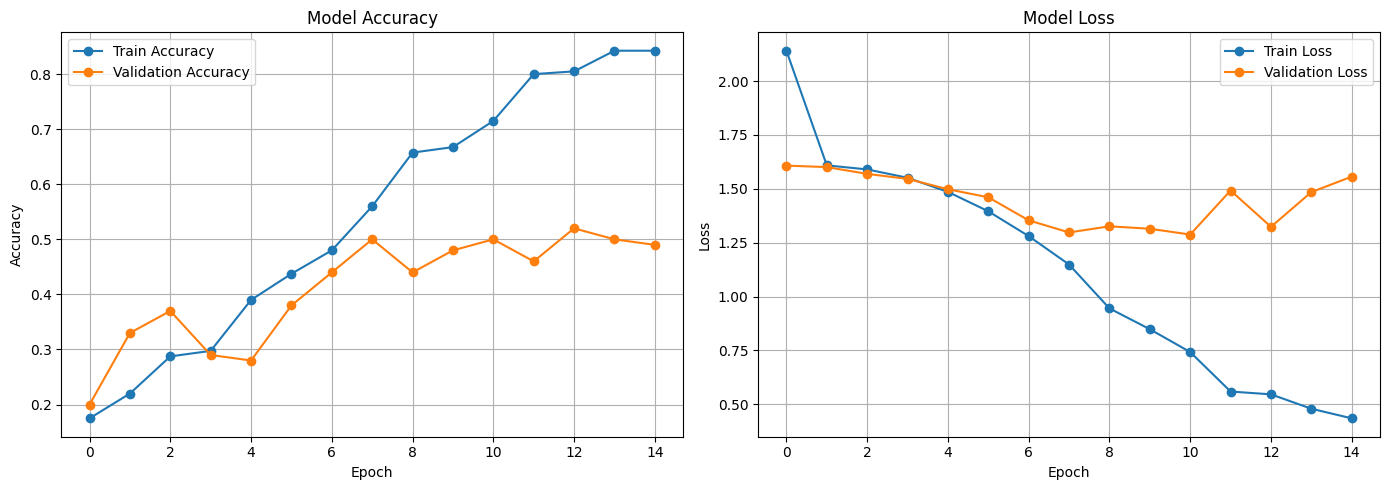

In [9]:
# --- Accuracy & Loss Plot ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()